In [80]:
import numpy as np
import torch as torch
import matplotlib.pyplot as plt
import sys
sys.path.append('C:/users/ffyrt/PycharmProjects/pythonProject4/public_folder/Package')
import Normalizer_to_denormalize2 as N2


In [52]:
model_NNWC = torch.jit.load('../model/Tau_NNWC.pt')
model_NNPC = torch.jit.load('../model/Tau_NNPC.pt')

In [19]:
##Load raw data
sparse_u = np.loadtxt('../data/sparse/u-instant-IDDES-hist.dat')
sparse_y = np.loadtxt('../data/sparse/yp-instant-IDDES.dat')
sparse_y2d = np.loadtxt('../data/sparse/y2d.dat')
#Load sparse data
dense_u = np.loadtxt('../data/dense/u-instant-IDDES-hist-all-y-every-90-dt.dat')
dense_y = np.loadtxt('../data/dense/yp-instant-IDDES-hist-all-y.dat')
dense_y2d = np.loadtxt('../data/dense/y2d.dat')

In [23]:
####LBM constants

##Height of the physical domain
h_phs = 2
##Viscosity of the physical domain
nu_phys = 1 / 5200
###Physical velocity of the main stream
u_phs = 24.35
##LB parameters of the physical domain
h_lb = 60
x_length = 600
dx = h_phs / h_lb
tau_lb = 0.5000378
cs2 = 1 / 3
nu_lb = cs2 * (tau_lb - 0.5)
dt = nu_lb / nu_phys * dx ** 2
LB_configuration = [dt, dx]
y_ref=nu_phys/dx
print("dt=", dt)
print("dx=", dx)
print('nu_lb=', nu_lb)

dt= 7.27999999999552e-05
dx= 0.03333333333333333
nu_lb= 1.2599999999992246e-05


In [24]:
def feature_builder(u, y):
    input1 = np.divide(np.abs(u), y) /dt/1000
    input2 = np.divide(np.log(y / y_ref), np.abs(u)*dx/dt)
    #input3=gradient
    return input1, input2


In [17]:
class Converter:

    def __init__(self, LB_configuration):
        (self.dt,self.dx) = LB_configuration
        

    def Phy2LB_u(self,u_dns):
        u_lb=u_dns*self.dt/self.dx
        return u_lb
    
    def Phy2LB_y(self,y_dns):
        y_lb=y_dns/self.dx
        return y_lb

    def LB_u2Phy(self,u_lb):
        u_phy=u_lb*self.dx/self.dt
        return u_phy
   
    def LB_y2Phy(self,y_lb):
        y_phy=y_lb*self.dx
        return y_phy

In [18]:
converter=Converter(LB_configuration)

In [29]:
#Set up the data and parameters(sparse data)
viscos=1/5200
yp_wall_sparse=sparse_y2d [1]/2
y0=2*yp_wall_sparse
u_wall_sparse=sparse_u[:,0]
ustar_sparse=(viscos*np.abs(u_wall_sparse)/yp_wall_sparse)**0.5

In [30]:
#Set up the data and parameters(dense data) 
viscos=1/5200
yp_wall_dense=dense_y2d [1]/2
y0=2*yp_wall_dense
u_wall_dense=dense_u[:,0]
ustar_dense=(viscos*np.abs(u_wall_dense)/yp_wall_dense)**0.5

In [ ]:
#Prepare for data of ground truth
Index = np.random.choice(range(len(dense_u)), 350)
Height_to_visualize =22
u_test = sparse_u[Index, Height_to_visualize]
y_test = np.tile(sparse_y[Height_to_visualize], (len(Index), 1))
u_lbm=converter.Phy2LB_u(u_test)
ustar_lbm = ustar_sparse[Index]

#ustar_lbm_prediction = converter.LB_u2Phy(z_test.detach().numpy())

In [53]:
#Prepare for data to predict
Index_test = np.random.choice(range(len(dense_u)), 50)
Height_to_visualize =22
u_test = sparse_u[Index_test, Height_to_visualize]
y_test = np.tile(sparse_y[Height_to_visualize], (len(Index_test), 1))
u_lbm_test=converter.Phy2LB_u(u_test)
y_lbm_test=converter.Phy2LB_y(y_test)
ustar_sampled_test = ustar_sparse[Index_test]
ustar_lbm_test=converter.Phy2LB_u(ustar_sampled_test)
(feature_test_1, feature_test_2) = feature_builder(u_lbm_test.reshape(-1, 1), y_lbm_test)
input_test_1 = feature_test_1
input_test_2 = feature_test_2
input_test = np.concatenate((input_test_1, input_test_2), axis=1)
z_test=model_NNWC(torch.tensor(input_test))
ustar_lbm_pred=converter.Phy2LB_u(ustar_sampled_test)
#ustar_lbm_prediction = converter.LB_u2Phy(z_test.detach().numpy())

In [87]:
#Prepare for prediction (NNWC model)
#Index_test = np.random.choice(range(len(dense_u)), 50)
#Height_to_visualize = 22
u_test = dense_u[Index_test, Height_to_visualize]
y_test = np.tile(dense_y[Height_to_visualize], (len(Index_test), 1))
u_lbm_test = converter.Phy2LB_u(u_test)
y_lbm_test = converter.Phy2LB_y(y_test)
ustar_sampled_test = ustar_dense[Index_test]
ustar_lbm_test = converter.Phy2LB_u(ustar_sampled_test)
(feature_test_1, feature_test_2) = feature_builder(u_lbm_test.reshape(-1, 1), y_lbm_test)
input_test_1 = feature_test_1
input_test_2 = feature_test_2
input_test = np.concatenate((input_test_1, input_test_2), axis=1)
z_test = model_NNWC(torch.tensor(input_test))
#ustar_lbm = converter.Phy2LB_u(ustar_sampled_test)
ustar_lbm_prediction = converter.Phy2LB_u(z_test.detach().numpy())

In [94]:
#Prepare for prediction (NNPC model)
Norm_in_max=np.loadtxt('Norm/Norm_in_max.txt')
Norm_in_min=np.loadtxt('Norm/Norm_in_min.txt')
Norm_out_max=np.loadtxt('Norm/Norm_out_max.txt')
Norm_out_min=np.loadtxt('Norm/Norm_out_min.txt')
Normalizer_in = N2.MinMaxNormalizer_configure(Norm_in_min,Norm_in_max)
Normalizer_out = N2.MinMaxNormalizer_configure(Norm_out_min,Norm_out_max)
Normalized_in_pred = Normalizer_in.normalize(input_test)
z_test=model_NNPC(torch.tensor(Normalized_in_pred))
ustar_lbm_prediction_NNPC=converter.Phy2LB_u(Normalizer_out.inverse_normalize(z_test.detach().numpy()))


In [ ]:
#######Save the data for visualization
#np.savetxt('utau_data_x.txt', u_lbm_pred)
#np.savetxt('utau_data_x_dns.txt', u_lbm)
#np.savetxt('utau_data_y.txt',  )
#np.savetxt('utau_data_x_prediction.txt', ustar_lbm_prediction)
#np.savetxt('utau_prediction_sparsePDF.txt', ustar_lbm_prediction_NNPC)


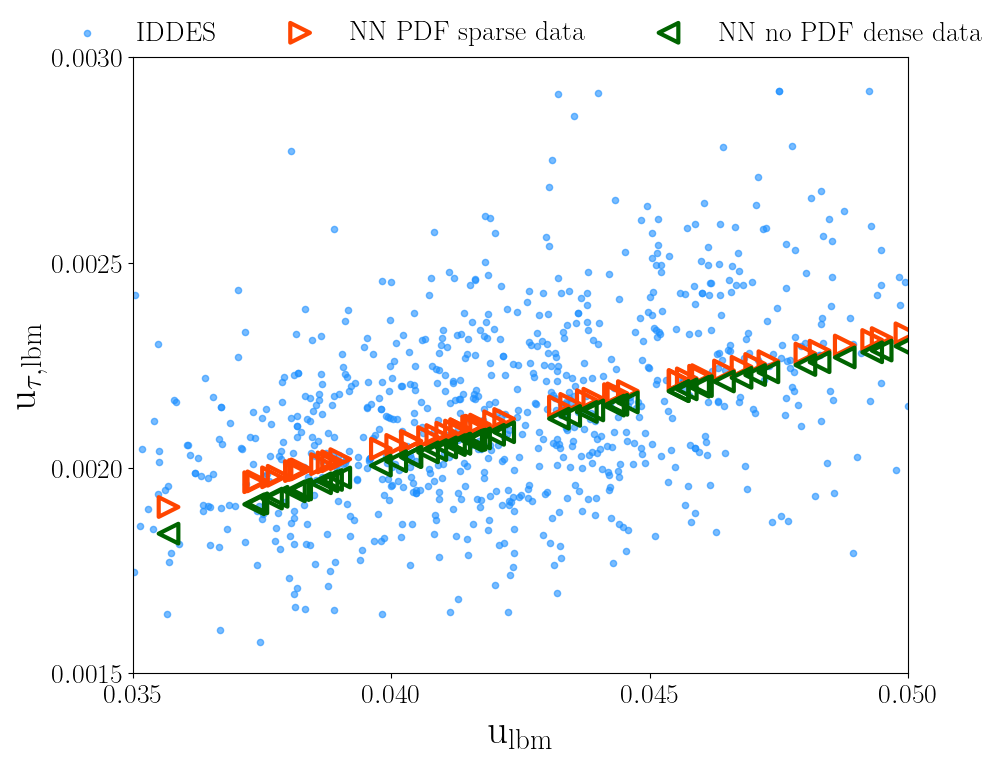

In [71]:
u_lbm_test_dns = np.loadtxt("utau_data_x_dns.txt")
ustar_sampled_test_lbm = np.loadtxt("utau_data_y.txt")
u_lbm_test = np.loadtxt("utau_prediction_x.txt")
##Prediction of NNPC model
predicted_ustar_lbm = np.loadtxt("utau_prediction_sparsePDF.txt")
##Prediction for NNWC model
predicted_ustar_lbm_full = np.loadtxt("utau_prediction_dense.txt")
from matplotlib import rc

plt.figure()
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern']})
rc('text', usetex=True)
rc('font', weight='bold', size=30)

plt.clf()
fig = plt.gcf()
fig.set_size_inches(10, 8)

plt.scatter(u_lbm_test_dns, ustar_sampled_test_lbm, marker='.', color='dodgerblue', alpha=0.6, s=80,
            label='$\mathrm{IDDES}$ ')
plt.scatter(u_lbm_test, predicted_ustar_lbm, marker='>', edgecolors='orangered', facecolors='none', s=200, linewidths=3,
            label=r'$\mathrm{NN}$ $\mathrm{PDF}$ $\mathrm{sparse}$ $\mathrm{data}$')
plt.scatter(u_lbm_test, predicted_ustar_lbm_full, marker='<', edgecolors='darkgreen', facecolors='none', s=200,
            linewidths=3, label=r'$\mathrm{NN}$ $\mathrm{no}$ $\mathrm{PDF}$ $\mathrm{dense}$ $\mathrm{data}$')

plt.xlabel('$\mathrm{u_{lbm}}$')
plt.ylabel('$\mathrm{u_{\\tau,lbm}}$')
plt.xticks(fontsize=20)  # Adjust the fontsize as needed
plt.yticks(fontsize=20)  # Adjust the fontsize as needed
plt.locator_params(axis='x', nbins=4)  # Set the number of ticks on the x-axis
plt.locator_params(axis='y', nbins=5)  # Set the number of ticks on the y-axis
axes = plt.gca()
axes.set_ylim([0.0015, 0.003])
axes.set_xlim([0.035, 0.05])

legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, shadow=False, fontsize=20, frameon=False)
frame = legend.get_frame()

plt.show()
fig.savefig('utau_yplus260_sparse_compare.pdf', dpi=300)